In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

jtplot.reset()


Bad key "text.kerning_factor" on line 4 in
/home/batu/anaconda3/envs/rnn/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
PATH = "tmp/df_1minute_1yearago"
df = pd.read_feather(PATH)

In [3]:
#import time
#for i in range(len(df)):
#    temp = df.iloc[i][6]
#    temp = temp[:-3]
#    temp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(temp)))
#    df.iloc[i][6] = temp    
#    print(temp)
#df.to_feather(PATH)

In [4]:
df_temp = df.drop(['open time','close time'], axis=1).astype('float')
df_temp.insert(loc= 0, column='open time', value=df['open time'])
df_temp.insert(loc= 6, column='close time', value=df['close time'])
df = df_temp

In [5]:
def create_time_steps(length):
  return list(range(-length, 0))

In [6]:
features_considered = ['open','close','high','low','volume']

In [7]:
features = df[features_considered]
features.index = df['close time']

In [8]:
TRAIN_SPLIT = 400000
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [10]:
tf.random.set_seed(13)
past_history = 10080
future_target = 60
STEP = 15
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 400
EPOCHS = 500

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [11]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [12]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [13]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 400 steps, validate for 50 steps
Epoch 1/500
400/400 [==============================] - 15s 38ms/step - loss: 0.0597 - val_loss: 0.0188
Epoch 2/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0416 - val_loss: 0.0250
Epoch 3/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0276 - val_loss: 0.0594
Epoch 4/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0206 - val_loss: 0.1012
Epoch 5/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0254 - val_loss: 0.0114
Epoch 6/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0360 - val_loss: 0.0336
Epoch 7/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0192 - val_loss: 0.0164
Epoch 8/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0213 - val_loss: 0.0270
Epoch 9/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0207 - val_loss: 0.0135
Epoch 10/500
400/400 [========

400/400 [==============================] - 11s 28ms/step - loss: 0.0228 - val_loss: 0.0152
Epoch 80/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0144 - val_loss: 0.0117
Epoch 81/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0144 - val_loss: 0.0109
Epoch 82/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0312 - val_loss: 0.0118
Epoch 83/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0196 - val_loss: 0.0191
Epoch 84/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0148 - val_loss: 0.0212
Epoch 85/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0151 - val_loss: 0.0109
Epoch 86/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0345 - val_loss: 0.0139
Epoch 87/500
400/400 [==============================] - 11s 29ms/step - loss: 0.0170 - val_loss: 0.0109
Epoch 88/500
400/400 [==============================] - 11s 28ms/step - loss:

400/400 [==============================] - 11s 28ms/step - loss: 0.0132 - val_loss: 0.0165
Epoch 158/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0274 - val_loss: 0.0166
Epoch 159/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0226 - val_loss: 0.0275
Epoch 160/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0141 - val_loss: 0.0108
Epoch 161/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0125 - val_loss: 0.0137
Epoch 162/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0365 - val_loss: 0.0246
Epoch 163/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0221 - val_loss: 0.0200
Epoch 164/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0138 - val_loss: 0.0118
Epoch 165/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 166/500
400/400 [==============================] - 11s 28ms/ste

400/400 [==============================] - 11s 28ms/step - loss: 0.0273 - val_loss: 0.0132
Epoch 236/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0134 - val_loss: 0.0109
Epoch 237/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 238/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0256 - val_loss: 0.0134
Epoch 239/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0219 - val_loss: 0.0118
Epoch 240/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0136 - val_loss: 0.0116
Epoch 241/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0125 - val_loss: 0.0143
Epoch 242/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0284 - val_loss: 0.0140
Epoch 243/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0187 - val_loss: 0.0274
Epoch 244/500
400/400 [==============================] - 11s 28ms/ste

400/400 [==============================] - 11s 28ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 314/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0185 - val_loss: 0.0144
Epoch 315/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0270 - val_loss: 0.0133
Epoch 316/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0133 - val_loss: 0.0192
Epoch 317/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0109 - val_loss: 0.0163
Epoch 318/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0245 - val_loss: 0.0169
Epoch 319/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0216 - val_loss: 0.0153
Epoch 320/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0135 - val_loss: 0.0110
Epoch 321/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0109 - val_loss: 0.0155
Epoch 322/500
400/400 [==============================] - 11s 28ms/ste

400/400 [==============================] - 11s 28ms/step - loss: 0.0285 - val_loss: 0.0158
Epoch 392/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0140 - val_loss: 0.0126
Epoch 393/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0112 - val_loss: 0.0137
Epoch 394/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0170 - val_loss: 0.0140
Epoch 395/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0263 - val_loss: 0.0135
Epoch 396/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 397/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0108 - val_loss: 0.0116
Epoch 398/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0227 - val_loss: 0.0166
Epoch 399/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0214 - val_loss: 0.0127
Epoch 400/500
400/400 [==============================] - 11s 28ms/ste

400/400 [==============================] - 11s 28ms/step - loss: 0.0292 - val_loss: 0.0164
Epoch 470/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0251 - val_loss: 0.0160
Epoch 471/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0306 - val_loss: 0.0271
Epoch 472/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 473/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 474/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0174 - val_loss: 0.0205
Epoch 475/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0278 - val_loss: 0.0198
Epoch 476/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0134 - val_loss: 0.0136
Epoch 477/500
400/400 [==============================] - 11s 28ms/step - loss: 0.0153 - val_loss: 0.0181
Epoch 478/500
400/400 [==============================] - 11s 28ms/ste

In [14]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

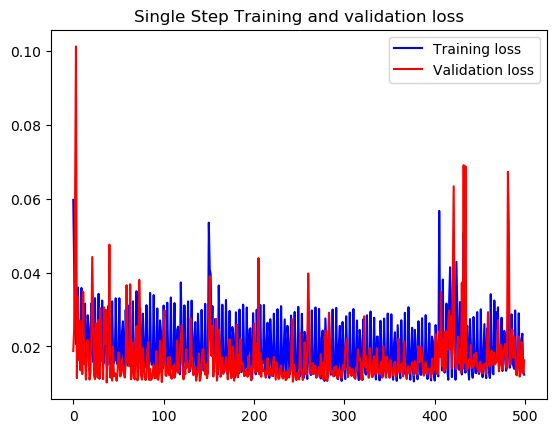

In [15]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

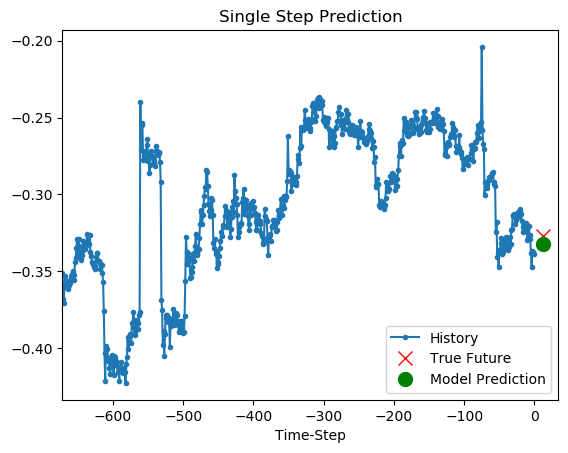

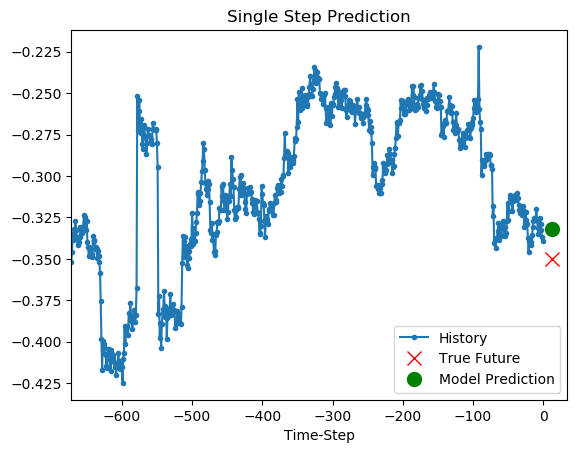

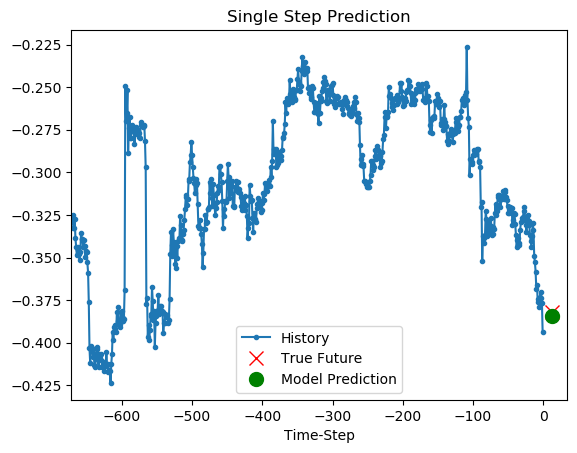

In [16]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()